In [2]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import PC
from pgmpy.base import DAG
from pgmpy.independencies import Independencies
import time

In [3]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [4]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_small = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_medium = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat")
# df_large = csv_format_discrete(r"")

### chi-squared test

In [5]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### Pearson's Product Moment Correlation Coefficient

In [6]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [7]:
#0th order chi2 test
def PMCC(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    R_list = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        R = pearsonr(X=i, Y=j, Z=[], data=df, significance_level=rho)
        R_list.append((i,j,R))
    true_0 = [x for x in R_list if True in x]
    false_0 = [x for x in R_list if False in x]
    return true_0, false_0

In [8]:
PMCC(df_gaus, 0.05)

([('A', 'B', True),
  ('A', 'D', True),
  ('A', 'E', True),
  ('A', 'G', True),
  ('B', 'E', True),
  ('B', 'G', True),
  ('C', 'E', True),
  ('C', 'G', True),
  ('D', 'E', True),
  ('D', 'G', True),
  ('E', 'G', True)],
 [('A', 'C', False),
  ('A', 'F', False),
  ('B', 'C', False),
  ('B', 'D', False),
  ('B', 'F', False),
  ('C', 'D', False),
  ('C', 'F', False),
  ('D', 'F', False),
  ('E', 'F', False),
  ('F', 'G', False)])

### Sorting Functions

In [11]:
def create_permutations(my_list):
    '''
    takes in a list, remove extra permutations from the list and only creates a pair of permutations
    '''
    p_permutations = []
    new_list = list(set(tuple(sorted(l[:2])) for l in my_list))
    for items in new_list:
        new_list_0 = list(itertools.permutations(items[:2],2))[1]
        p_permutations.append(new_list_0)
    return new_list + p_permutations

In [12]:
#given 2 lists, append them together and remove duplicates
def remove_permutations(list_):
    '''
    returns a sorted list without permutation
    '''
    return sorted(list(set(tuple(sorted(l[:2])) for l in list_)))

### 1st order CI

In [ ]:
#1st order CI
def cond_1_generate(df, rho):
    v = list(df)
    p_permutations = list(itertools.permutations(v,3))
    order_0 = create_permutations(chi2bool(df, rho)[0])
    generated = [x for x in p_permutations if x[:2] not in order_0]
    generated_0 = set(tuple(sorted(items[:2])) for items in generated)
    generate_return = [x for x in generated if x[:2] in generated_0]
    return generate_return

In [ ]:
def cond_1_test(df, rho):
    chi2_data = []
    phi = cond_1_generate(df, rho)
    for i,j,k in phi:
        chi2 = chi_square(X=i, Y=j, Z=[k], data=df, significance_level=rho)
        chi2_data.append((i,j,k,chi2))
    true_list = [x for x in chi2_data if True in x]
    false_list = [x for x in chi2_data if False in x]
    return true_list, false_list

### CONDITIONAL MAIN CODE

In [9]:
def PC_(df, n, rho):
    '''
    Note:
    This function will start from at least 0th order CI
    
    Parameters:
    df (pandas dataframe)
    n an integer, the stopping point of the while loop
    rho (the significance level, only accepts values between 0 and 1 inclusive)
    
    Returns:
    A list which contains every independent X and Y
    '''
    N = 3
    v = list(df)
    # remove_list = [x for x in p_permute]
    remove_list = create_permutations([x[:2] for x in chi2bool(df, rho)[0]])
    #x[:2] for 0th order and its permutations, so we can later remove it 
    empty_list = []
    while N <= n:
        list_permutations = [x for x in itertools.permutations(v, N) if x[:2] not in remove_list]
        p_1, p_2, p_3 = [x[:1] for x in list_permutations], [x[1:2] for x in list_permutations], [x[2:] for x in list_permutations]
        for i,j,k in zip(p_1, p_2, p_3):
            chi2 = chi_square(X=i[0], Y=j[0], Z=k, data=df, significance_level=rho)
            empty_list.append((i[0],j[0],k,chi2))
        true_list = create_permutations([x[:2] for x in empty_list if True in x])
        #create_permutations ensures only 1 set of permutations of (X,Y) and (Y,X) and removes dupes
        remove_list = remove_list + create_permutations(true_list)
        remove_list = create_permutations(remove_list)
        N += 1
        
    return remove_permutations(remove_list) #returns 1 set of permutations

#ON MEDIUM SIZED NETWORKS:
#1st order CI takes 2minutes to run
#2nd order CI 9-15minutes to run
#nP5 takes ??? minutes to run
#nP6 not doable

In [13]:
%%time
c4 = PC_(df_medium,3,0.01)

CPU times: total: 44.8 s
Wall time: 45.8 s


In [ ]:
c4

### small network

In [30]:
m = Gobnilp()

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


In [27]:
%%time
y_small = PC_(df_small, 4, 0.05)
for i,j in y_small:
        m.add_obligatory_independence([i],[j])

CPU times: total: 6.19 s
Wall time: 6.26 s


In [146]:
removal = [x[:2] for x in chi2bool(df_small, 0.05)[0]]
removal

[('One', 'Four'),
 ('One', 'Five'),
 ('Two', 'Four'),
 ('Two', 'Five'),
 ('Three', 'Four'),
 ('Four', 'Six'),
 ('Four', 'Seven'),
 ('Four', 'Eight')]

In [176]:
m.adjacency

{frozenset({'Eight', 'Five'}): <gurobi.Var Eight-Five (value -0.0)>,
 frozenset({'Eight', 'One'}): <gurobi.Var Eight-One (value -0.0)>,
 frozenset({'Eight', 'Seven'}): <gurobi.Var Eight-Seven (value -0.0)>,
 frozenset({'Eight', 'Six'}): <gurobi.Var Eight-Six (value 1.0)>,
 frozenset({'Eight', 'Three'}): <gurobi.Var Eight-Three (value 1.0)>,
 frozenset({'Eight', 'Two'}): <gurobi.Var Eight-Two (value -0.0)>,
 frozenset({'Five', 'Four'}): <gurobi.Var Five-Four (value 0.0)>,
 frozenset({'Five', 'Seven'}): <gurobi.Var Five-Seven (value -0.0)>,
 frozenset({'Five', 'Six'}): <gurobi.Var Five-Six (value 1.0)>,
 frozenset({'Five', 'Three'}): <gurobi.Var Five-Three (value -0.0)>,
 frozenset({'One', 'Seven'}): <gurobi.Var One-Seven (value -0.0)>,
 frozenset({'One', 'Six'}): <gurobi.Var One-Six (value -0.0)>,
 frozenset({'One', 'Three'}): <gurobi.Var One-Three (value 1.0)>,
 frozenset({'One', 'Two'}): <gurobi.Var One-Two (value 1.0)>,
 frozenset({'Seven', 'Six'}): <gurobi.Var Seven-Six (value 1.0)>

In [172]:
for i in m.adjacency:
    print(i)

frozenset({'Five', 'Eight'})
frozenset({'One', 'Eight'})
frozenset({'Eight', 'Seven'})
frozenset({'Six', 'Eight'})
frozenset({'Three', 'Eight'})
frozenset({'Eight', 'Two'})
frozenset({'Four', 'Five'})
frozenset({'Five', 'Seven'})
frozenset({'Six', 'Five'})
frozenset({'Five', 'Three'})
frozenset({'One', 'Seven'})
frozenset({'Six', 'One'})
frozenset({'One', 'Three'})
frozenset({'One', 'Two'})
frozenset({'Six', 'Seven'})
frozenset({'Three', 'Seven'})
frozenset({'Seven', 'Two'})
frozenset({'Six', 'Three'})
frozenset({'Six', 'Two'})
frozenset({'Three', 'Two'})


In [199]:
F = []
for i,j in m.adjacency.items():
    if j.X == 1:
        F.append(i)

In [207]:
F
J = ([list(x) for x in F])
p_1 = [x[0] for x in J]
p_1, J

(['Six', 'Three', 'Six', 'One', 'One', 'Six', 'Six'],
 [['Six', 'Eight'],
  ['Three', 'Eight'],
  ['Six', 'Five'],
  ['One', 'Three'],
  ['One', 'Two'],
  ['Six', 'Seven'],
  ['Six', 'Two']])

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -22466.396546491495
**********
Eight<-Six,Three -4150.291729106073
Six<-Five,Two -5.611578690688475
Three<- -6901.1493808303785
Five<-Four -633.8404777927353
Four<- -527.7536882896093
One<-Three -6460.081285708176
Seven<-Six -1881.452188461728
Two<-One -1906.2162176121055
**********
bnlearn modelstring = 
[Eight|Six:Three][Six|Five:Two][Three][Five|Four][Four][One|Three][Seven|Six][Two|One]
**********
CPDAG:
Vertices: Eight,Six,Three,Five,Four,One,Seven,Two
Six->Eight
Six->Seven
Three->Eight
Three-One
Five->Six
Four-Five
One-Two
Two->Six



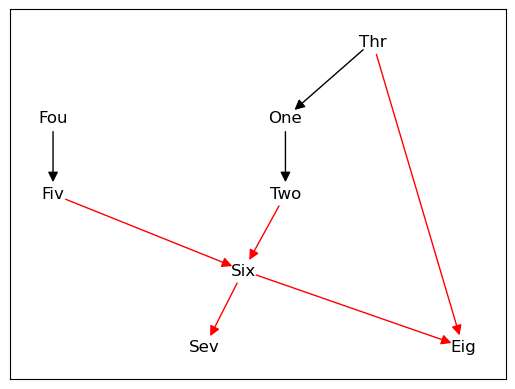

**********
BN has score -22466.396546491495
**********
Eight<-Six,Three -4150.291729106073
Six<-Five,Two -5.611578690688475
Three<- -6901.1493808303785
Five<-Four -633.8404777927353
Four<- -527.7536882896093
One<-Three -6460.081285708176
Seven<-Six -1881.452188461728
Two<-One -1906.2162176121055
**********
bnlearn modelstring = 
[Eight|Six:Three][Six|Five:Two][Three][Five|Four][Four][One|Three][Seven|Six][Two|One]
**********
CPDAG:
Vertices: Eight,Six,Three,Five,Four,One,Seven,Two
Six->Eight
Six->Seven
Three->Eight
Three-One
Five->Six
Four-Five
One-Two
Two->Six



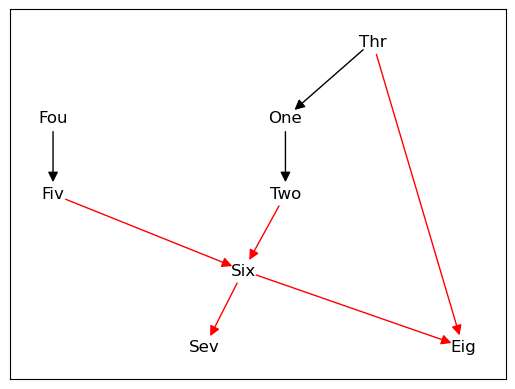

CPU times: total: 7.05 s
Wall time: 4.1 s


In [209]:
%%time
m = Gobnilp()
N = 0
n = 2
chi_list = []
while N < n:
    empty_list = []
    m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat', palim=None)
    for i,j in m.adjacency.items():
        if j.X == 1.0:
            empty_list.append(i)
    #chi2 test
    empty_list = [list(x) for x in empty_list]
    phi_0, phi_1 = [x[0] for x in empty_list], [x[1] for x in empty_list]
    for i,j in zip(phi_0, phi_1):
        chi2 = chi_square(X=i, Y=j, Z=[], data=df_small, significance_level=0.05)
        chi_list.append((i,j,chi2))
    N += 1

In [210]:
chi_list

[('Six', 'Eight', False),
 ('Three', 'Eight', False),
 ('Four', 'Five', False),
 ('Six', 'Five', False),
 ('One', 'Three', False),
 ('One', 'Two', False),
 ('Six', 'Seven', False),
 ('Six', 'Two', False),
 ('Six', 'Eight', False),
 ('Three', 'Eight', False),
 ('Four', 'Five', False),
 ('Six', 'Five', False),
 ('One', 'Three', False),
 ('One', 'Two', False),
 ('Six', 'Seven', False),
 ('Six', 'Two', False)]

In [136]:
t_list = []
for i in m.getVars():
    if i.X == 1:
        t_list.append(i.varName)

In [144]:
for i in t_list:
    if '<-{}' not in i:
        print(i)

Eight<-{Six,Three}
Five<-{Four}
One<-{Three}
Seven<-{Six}
Six<-{Five,Two}
Two<-{One}
Five->Six
Four->Five
One->Two
Six->Eight
Six->Seven
Three->Eight
Three->One
Two->Six
Eight-Six
Eight-Three
Five-Four
Five-Six
One-Three
One-Two
Seven-Six
Six-Two


In [133]:
all_vars = m.getVars()
values = m.getAttr("X", all_vars)
names = m.getAttr("VarName", all_vars)
for name, val in zip(names, values):
    print(f"{name} = {val}")

Eight<-{} = -0.0
Eight<-{Five} = -0.0
Eight<-{One} = -0.0
Eight<-{Seven} = -0.0
Eight<-{Six} = -0.0
Eight<-{Three} = -0.0
Eight<-{Two} = -0.0
Eight<-{Five,One} = -0.0
Eight<-{Five,Seven} = -0.0
Eight<-{Five,Three} = -0.0
Eight<-{Five,Two} = -0.0
Eight<-{One,Seven} = -0.0
Eight<-{One,Six} = -0.0
Eight<-{One,Three} = -0.0
Eight<-{One,Two} = -0.0
Eight<-{Seven,Three} = -0.0
Eight<-{Seven,Two} = -0.0
Eight<-{Six,Three} = 1.0
Eight<-{Three,Two} = -0.0
Eight<-{Five,One,Seven} = -0.0
Eight<-{Five,One,Two} = -0.0
Eight<-{Five,Seven,Three} = -0.0
Eight<-{Five,Three,Two} = -0.0
Eight<-{Seven,Three,Two} = -0.0
Five<-{} = -0.0
Five<-{Eight} = -0.0
Five<-{Four} = 1.0
Five<-{Seven} = -0.0
Five<-{Six} = -0.0
Five<-{Eight,Four} = -0.0
Five<-{Eight,One} = -0.0
Five<-{Eight,Seven} = -0.0
Five<-{Eight,Three} = -0.0
Five<-{Four,Seven} = -0.0
Five<-{Four,Six} = -0.0
Five<-{One,Seven} = -0.0
Five<-{One,Six} = -0.0
Five<-{Seven,Three} = -0.0
Five<-{Seven,Two} = -0.0
Five<-{Six,Three} = -0.0
Five<-{Six,Two} =

In [108]:
k = m.arrow.values()
u = [x for x in k if x.X == 1]

In [ ]:
s = Gobnilp()
s.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')

### medium-sized network

In [ ]:
m_medium = Gobnilp()

In [ ]:
%%time 
y_medium = PC_(df_medium, 2, 0.05)
for i,j in y_medium:
        m_medium.add_obligatory_independence([i],[j])

In [ ]:
%%time
# m_medium.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat')

In [ ]:
%%time
m_medium.learn(start='MIP solution')

In [ ]:
m0 = Gobnilp()

In [ ]:
%%time
m0.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')

In [ ]:
%%time
m.learn(start='MIP solution', palim=10)

In [ ]:
(list(m.forbidden_arrows))

### PC Algorithm

In [17]:
c = PC(data=df_small)

In [18]:
model = c.estimate(max_cond_vars=2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
%%time
ind = model.get_independencies()

CPU times: total: 31.2 ms
Wall time: 29.7 ms


In [25]:
ind_PC_ = PC_(df_small, 2, 0.01)
ind_PC_

[('Eight', 'Four'),
 ('Five', 'One'),
 ('Five', 'Three'),
 ('Five', 'Two'),
 ('Four', 'One'),
 ('Four', 'Seven'),
 ('Four', 'Six'),
 ('Four', 'Three'),
 ('Four', 'Two')]

In [23]:
ind

(Five ⟂ Three, Eight, Six, One, Seven, Two)
(Five ⟂ Three, Eight, Six, One, Seven, Two | Four)
(Five ⟂ Three, Six, One, Seven, Two | Eight)
(Five ⟂ Eight, Six, One, Seven, Two | Three)
(Five ⟂ Three, Eight, One, Seven, Two | Six)
(Five ⟂ Three, Eight, Six, Seven, Two | One)
(Five ⟂ Eight, Three, Six, One, Two | Seven)
(Five ⟂ Three, Eight, Six, One, Seven | Two)
(Five ⟂ Three, Six, One, Seven, Two | Four, Eight)
(Five ⟂ Eight, Six, One, Seven, Two | Four, Three)
(Five ⟂ Three, Eight, One, Seven, Two | Four, Six)
(Five ⟂ Three, Eight, Six, Seven, Two | Four, One)
(Five ⟂ Eight, Three, Six, One, Two | Four, Seven)
(Five ⟂ Three, Eight, Six, One, Seven | Four, Two)
(Five ⟂ Six, One, Seven, Two | Three, Eight)
(Five ⟂ One, Three, Seven, Two | Six, Eight)
(Five ⟂ Six, Three, Seven, Two | One, Eight)
(Five ⟂ Six, One, Three, Two | Eight, Seven)
(Five ⟂ Six, One, Three, Seven | Eight, Two)
(Five ⟂ One, Eight, Seven, Two | Six, Three)
(Five ⟂ Six, Eight, Seven, Two | One, Three)
(Five ⟂ Six, O

In [ ]:
pdag = c.skeleton_to_pdag(*c.build_skeleton())

In [ ]:
list(pdag.edges())

In [ ]:
m_medium.add_obligatory_adjacency()

In [ ]:
print(model.edges())